# Evaluate the change of watermass and OMZ volume per model

In [1]:
from distributed import LocalCluster, Client
mem_total = 300
workers = 6
threads = 6# more threads work a looooot better for the trend calculation (less comms)

cluster = LocalCluster(
    memory_limit=f"{int(mem_total/workers)}GiB",
    dashboard_address=9999,
    threads_per_worker=threads,
    n_workers = workers,
                      )
client = Client(cluster)
client

distributed.diskutils - INFO - Found stale lock file and directory '/projects/GEOCLIM/LRGROUP/jbusecke/projects/busecke_etal_2021_aguadv/notebooks/dask-worker-space/worker-__s2t3z2', purging


Connection method: Cluster object,Cluster type: LocalCluster
Dashboard: http://127.0.0.1:9999/status,
Status: running,Using processes: True
Dashboard: http://127.0.0.1:9999/status,Workers: 4
Total threads: 24,Total memory: 300.00 GiB
Comm: tcp://127.0.0.1:45459,Workers: 4
Dashboard: http://127.0.0.1:9999/status,Total threads: 24
Started: Just now,Total memory: 300.00 GiB
Comm: tcp://127.0.0.1:41776,Total threads: 6
Dashboard: http://127.0.0.1:39413/status,Memory: 75.00 GiB
Nanny: tcp://127.0.0.1:42924,


In [2]:
# %load_ext autoreload
# %autoreload 2

In [3]:
from fastjmd95 import rho

In [4]:
import cmip6_preprocessing
cmip6_preprocessing.__path__

['/home/jbusecke/code/cmip6_preprocessing/cmip6_preprocessing']

In [5]:
import cmip6_preprocessing
cmip6_preprocessing.__version__

'0.5.1.dev2+g94d0171.d20210728'

In [6]:
from dask.diagnostics import ProgressBar
import numpy as np

In [ ]:
import xarray as xr
import numpy as np
import pathlib
# from cmip6_preprocessing.postprocessing import concat_members
from cmip6_omz.omz_tools import mask_basin
from cmip6_omz.upstream_stash import flatten_dict, load_data_to_nested_dict, concat_experiments, concat_members
from busecke_etal_2021_aguadv.utils import mask_basin
import matplotlib.pyplot as plt
from fastprogress.fastprogress import progress_bar

def mask_pac_tropics(ds_in):
    ds_pac = mask_basin(ds_in)
    # mask out the tropics
    ds_pac = ds_pac.where(abs(ds_pac.lat)<=30)
    return ds_pac

In [8]:
import intake
import pathlib
import xarray as xr

from fastprogress import progress_bar
from cmip6_omz.boundaries import omz_boundaries
from cmip6_omz.utils import cmip6_collection, o2_models
from cmip6_preprocessing.utils import cmip6_dataset_id
from cmip6_preprocessing.drift_removal import match_and_remove_trend
from cmip6_preprocessing.preprocessing import combined_preprocessing
from cmip6_preprocessing.postprocessing import interpolate_grid_label, merge_variables, match_metrics
from xarrayutils.file_handling import write
from distributed import LocalCluster, Client
from cmip6_omz.upstream_stash import concat_experiments, pick_first_member, transform_wrapper

In [9]:
from xarrayutils.utils import (
    remove_bottom_values,
    #mask_mixedlayer
)
from cmip6_omz.omz_tools import (
    omz_thickness,
    sigma_bins,
    align_missing,
    preprocessing_wrapper,
)

In [10]:
# Load all trend files
flist = list(pathlib.Path('../../cmip6_omz/data/temp/julius_temp/fine_density_tests_combined/').absolute().glob('*.zarr'))
ddict = {}
for f in progress_bar(flist):
    ddict[f.stem] = xr.open_zarr(f)

In [11]:
ddict_combined = {k:ds for k, ds in ddict.items()}
# ddict_combined = concat_experiments(ddict)
# ddict_combined = {k:ds for k,ds in ddict_combined.items() if len(ds.time)>=250}
# # ddict_combined = concat_members(ddict_combined, match_attr_ignore=['variant_label', 'experiment_id'])mask_basin

## Inconclusive First Plot

In [13]:
# for name, ds in ddict_combined.items():
#     print(name)
#     # mask out the pacific
#     ds_pac = mask_pac_tropics(ds)
    
    
#     vol = (ds_pac.dz_t * ds_pac.areacello).sum(['x', 'y'])
#     omz_vol = (ds_pac.omz_thickness * ds_pac.areacello).sel(o2_bin=80).sum(['x', 'y'])
#     with ProgressBar():
#         plt.figure(figsize=[10,5])

#         # timeseries of Full OMZ and Volume
#         plt.subplot(2,2,3)
#         ref_omz_vol = omz_vol.isel(time=0).sum('sigma_0')
#         (((omz_vol.sum('sigma_0')-ref_omz_vol)/ref_omz_vol)*100).plot(label='Full OMZ volume change')

#         ref_vol = vol.isel(time=0).sum('sigma_0')
#         ((vol.sum('sigma_0')-ref_vol)/ref_vol*100).plot(label='Full volume change')
#         plt.ylabel('[%]')

#         # Hovmoellers

#         plt.subplot(2,2,1)
#         (omz_vol - (omz_vol.sel(time=slice('1850','1900')).mean('time'))).plot(x='time')
#         plt.ylim(28,24)
#         plt.title(f'OMZ Vol {name}')

#         plt.subplot(2,2,2)
#         (vol - (vol.sel(time=slice('1850','1900')).mean('time'))).plot(x='time')
#         plt.ylim(28,24)
#         plt.title(f'Full Vol {name}')

#         plt.show()

## Notes

OHHHHH when I take the full pacific the volume expands everywhere! This is not the case for the tropics!

## Prototype the 'control' shift of the historical OMZ in density space

In [14]:
col = intake.open_esm_datastore(cmip6_collection(zarr=True)) # Takes wayyy to long for now

kwargs = {
    "preprocess": combined_preprocessing,
    "cdf_kwargs": {"use_cftime": True, "chunks":{'time':3}, 'engine':'h5netcdf'},
    "zarr_kwargs": {'use_cftime': True, 'consolidated':True},
    "aggregate": False,
}
regress_vars = ['o2', 'thetao', 'so']

# models = [m for m in o2_models() if not ('NorESM' in m)] #Nor ESM has the problem with metric time not matching.
models = ['CanESM5', 'CanESM5-CanOE', 'CNRM-ESM2-1']
    
cat = col.search(
    source_id=models, 
    variable_id=regress_vars,
    experiment_id=['historical', 'ssp585']
)
ddict_raw_idealized = cat.to_dataset_dict(**kwargs)

# load metrics
cat_metrics = col.search(
    source_id=models, 
    variable_id=['thkcello', 'areacello'],
)
ddict_metrics_idealized = cat_metrics.to_dataset_dict(**kwargs)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.version.zstore'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.version.zstore'


> Why are there messages about MIROC if I didnt request that?

In [15]:
# again filter the 'short' CNRM member
ddict_raw_idealized = {k:ds for k, ds in ddict_raw_idealized.items() if not all([a in k for a in ['CNRM-ESM2-1', 'r6i1p1f2']])}

In [16]:
ddict_idealized = match_metrics(ddict_raw_idealized, ddict_metrics_idealized, ['areacello', 'thkcello'])

In [17]:
# Load all trend files
flist = list(pathlib.Path('../../cmip6_omz/data/external/cmip6_control_drifts/').absolute().glob('*.nc'))
trend_dict = {}
for f in progress_bar(flist):
    trend_dict[f.stem] = xr.open_mfdataset([f])

# detrend
ddict_detrended_idealized = match_and_remove_trend(
    ddict_idealized,
    trend_dict,
    check_mask=False # should be deactivated once the trends are completed (i have a few in there now that dont have a nanmask applied)
)

/home/jbusecke/code/cmip6_preprocessing/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CCCma.CanESM5.historical.r27i1p2f1.Omon.gn.v20190429
  warnings.warn(nomatch_msg)
/home/jbusecke/code/cmip6_preprocessing/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CCCma.CanESM5.historical.r34i1p2f1.Omon.gn.v20190429
  warnings.warn(nomatch_msg)
/home/jbusecke/code/cmip6_preprocessing/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CCCma.CanESM5.historical.r17i1p1f1.Omon.gn.v20190429
  warnings.warn(nomatch_msg)
/home/jbusecke/code/cmip6_preprocessing/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CCCma.CanESM5.historical.r35i1p2f1.Omon.gn.v20190429
  warnings.warn(nomatch_msg)
/home/jbusecke/code/cmip6_preprocessing/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching

In [18]:
# ddict_combined_idealized = pick_first_member(concat_experiments(merge_variables(ddict_detrended_idealized), exclude_attrs=['variable_id']))
ddict_combined_idealized = concat_experiments(merge_variables(ddict_detrended_idealized), exclude_attrs=['variable_id'])

# filter incomplete datasets
ddict_combined_idealized = {k:ds for k,ds in ddict_combined_idealized.items() if all([va in ds.variables for va in ['thetao', 'so', 'o2', 'areacello', 'thkcello']])}

/home/jbusecke/code/cmip6_preprocessing/cmip6_preprocessing/postprocessing.py:122: UserWarning: CMIP.CNRM-CERFACS.CNRM-ESM2-1.historical.r3i1p1f2.Omon.gn.none failed to combine with :'thetao' is not present in all datasets.
  warnings.warn(f"{cmip6_dataset_id(ds)} failed to combine with :{e}")
/home/jbusecke/code/cmip6_preprocessing/cmip6_preprocessing/postprocessing.py:122: UserWarning: ScenarioMIP.CNRM-CERFACS.CNRM-ESM2-1.ssp585.r2i1p1f2.Omon.gn.none failed to combine with :'thetao' is not present in all datasets.
  warnings.warn(f"{cmip6_dataset_id(ds)} failed to combine with :{e}")


In [20]:
list(np.sort(list(ddict_combined_idealized.keys())))

['CNRM-ESM2-1.gn.Omon.r10i1p1f2',
 'CNRM-ESM2-1.gn.Omon.r11i1p1f2',
 'CNRM-ESM2-1.gn.Omon.r1i1p1f2',
 'CNRM-ESM2-1.gn.Omon.r4i1p1f2',
 'CNRM-ESM2-1.gn.Omon.r5i1p1f2',
 'CNRM-ESM2-1.gn.Omon.r7i1p1f2',
 'CNRM-ESM2-1.gn.Omon.r8i1p1f2',
 'CNRM-ESM2-1.gn.Omon.r9i1p1f2',
 'CanESM5-CanOE.gn.Omon.r1i1p2f1',
 'CanESM5-CanOE.gn.Omon.r2i1p2f1',
 'CanESM5-CanOE.gn.Omon.r3i1p2f1',
 'CanESM5.gn.Omon.r10i1p1f1',
 'CanESM5.gn.Omon.r10i1p2f1',
 'CanESM5.gn.Omon.r11i1p1f1',
 'CanESM5.gn.Omon.r12i1p1f1',
 'CanESM5.gn.Omon.r13i1p1f1',
 'CanESM5.gn.Omon.r14i1p1f1',
 'CanESM5.gn.Omon.r15i1p1f1',
 'CanESM5.gn.Omon.r16i1p1f1',
 'CanESM5.gn.Omon.r1i1p1f1',
 'CanESM5.gn.Omon.r1i1p2f1',
 'CanESM5.gn.Omon.r2i1p1f1',
 'CanESM5.gn.Omon.r2i1p2f1',
 'CanESM5.gn.Omon.r3i1p1f1',
 'CanESM5.gn.Omon.r3i1p2f1',
 'CanESM5.gn.Omon.r4i1p1f1',
 'CanESM5.gn.Omon.r4i1p2f1',
 'CanESM5.gn.Omon.r5i1p1f1',
 'CanESM5.gn.Omon.r5i1p2f1',
 'CanESM5.gn.Omon.r6i1p1f1',
 'CanESM5.gn.Omon.r6i1p2f1',
 'CanESM5.gn.Omon.r7i1p1f1',
 'CanESM5.gn

In [21]:
# global parameters
o2_bins = np.array([10, 40, 60, 80, 100, 120])
fine_sigma_bins = sigma_bins()
fine_sigma_bins

array([  0.  ,  22.5 ,  22.75,  23.  ,  23.25,  23.5 ,  23.75,  24.  ,
        24.25,  24.5 ,  24.75,  25.  ,  25.25,  25.5 ,  25.75,  26.  ,
        26.25,  26.5 ,  26.55,  26.6 ,  26.65,  26.7 ,  26.75,  26.8 ,
        26.85,  26.9 ,  26.95,  27.  ,  27.05,  27.1 ,  27.15,  27.2 ,
        27.25,  27.3 ,  27.35,  27.4 ,  27.45,  27.5 ,  27.55,  27.6 ,
        27.65,  27.7 ,  27.75,  27.8 ,  27.85, 100.  ])

In [22]:
# # slow this down while the rest is processing

# import dask
# from multiprocessing.pool import ThreadPool
# dask.config.set(pool=ThreadPool(10))

In [23]:
list(ddict_combined.keys())

['none.NOAA-GFDL.GFDL-ESM4.none.r1i1p1f1.Omon.gn.none_r1i1p1f1',
 'none.MRI.MRI-ESM2-0.none.r1i2p1f1.Omon.gn.none_r1i2p1f1',
 'none.IPSL.IPSL-CM6A-LR.none.r6i1p1f1.Omon.gn.none_r6i1p1f1',
 'none.none.MPI-ESM1-2-HR.none.r1i1p1f1.Omon.gn.none_r1i1p1f1',
 'none.MPI-M.MPI-ESM1-2-LR.none.r4i1p1f1.Omon.gn.none_r4i1p1f1',
 'none.CCCma.CanESM5.none.r6i1p2f1.Omon.gn.v20190429_r6i1p2f1',
 'none.CNRM-CERFACS.CNRM-ESM2-1.none.r4i1p1f2.Omon.gn.none_r4i1p1f2',
 'none.MOHC.UKESM1-0-LL.none.r4i1p1f2.Omon.gn.none_r4i1p1f2',
 'none.MIROC.MIROC-ES2L.none.r1i1p1f2.Omon.gn.none_r1i1p1f2',
 'none.CCCma.CanESM5-CanOE.none.r3i1p2f1.Omon.gn.v20190429_r3i1p2f1',
 'none.CCCma.CanESM5-CanOE.none.r1i1p2f1.Omon.gn.v20190429_r1i1p2f1']

In [44]:
# from busecke_etal_2021_aguadv.temp_debug import idealized_output, full_sigma_treatment

def idealized_output(ds_source):
    
    ds_source = ds_source.copy()
    # average the thickness in time

    dz_t = ds_source.thkcello
    if "time" in dz_t:
        dz_t = dz_t.mean("time").load()

    ds_source = ds_source.drop("thkcello")
    ds_source = ds_source.assign(dz_t=dz_t)

    so = ds_source.so
    thetao = ds_source.thetao
    sigma = rho(so, thetao, 0) - 1000
    ds_source = ds_source.assign(sigma_0=sigma)
    
    # Create averages

    with ProgressBar():
        ds_hist = historic_mean(ds_source).load()
        ds_forced = forced_mean(ds_source).load()
        
    
    
    # replace the density in the hypthetic case with the forced density
    forced_sigma = ds_forced.sigma_0
    
    ds_idealized = ds_hist.copy(deep=True)
    ds_idealized = ds_idealized.assign(sigma_0=forced_sigma)


    return ds_hist, ds_idealized


def historic_mean(ds):
    return ds.sel(time=slice("1900", "1950")).mean("time")


def forced_mean(ds):
    return ds.sel(time=slice("2050", "2100")).mean("time")


def plot_prep(ds_plot):
    # mask pacific
    ds_masked = mask_pac_tropics(ds_plot).sel(o2_bin=80)
    omz_vol = ds_masked.omz_thickness * ds_masked.areacello
    return omz_vol.sum(['x','y'])

In [56]:
def full_sigma_treatment(ds_in):
    """DO NOT USE THIS AS A GENERAL WRAPPER!! THE SIGMA STUFF IS DIFFERENT"""
    ds_in = ds_in.set_coords('dz_t')
    ds_in = preprocessing_wrapper(ds_in)
    #perform nan-masking functions
    ds_in = align_missing(ds_in)

    ds_in = remove_bottom_values(ds_in)
    
    ds_in["omz_thickness"] = omz_thickness(
        ds_in, o2_bins=o2_bins
    )
    
    ds_sigma = transform_wrapper(ds_in, sigma_bins=fine_sigma_bins)
    return ds_sigma

In [ ]:
for name, ds_idealized in ddict_combined_idealized.items():
    print("---------------------------")
    print(name)

    # find the appropriate matching dataset
    ds_sigma_full_list = [
        model
        for k, model in ddict_combined.items()
        if all(
            [
                ds_idealized.attrs[ma] == model.attrs[ma]
                for ma in ["source_id", "variant_label"]
            ]
        )
    ]

    if not "IPSL" not in name:
        continue
    else:

        if len(ds_sigma_full_list) == 0:
            print("DIDNT FIND A MATCH FOR THIS ONE")
            continue
        else:
            if len(ds_sigma_full_list) > 1:
                print("HUHHHHH?")
            ds_reference = ds_sigma_full_list[0]

            for ma in ["source_id", "grid_label", "table_id", "variant_label"]:
                print(ds_idealized.attrs[ma])
                print(ds_reference.attrs[ma])
                assert ds_idealized.attrs[ma] == ds_reference.attrs[ma]

            ds_test_hist, ds_test_forced = idealized_output(ds_idealized)
            
            assert "omz_thickness" not in ds_test_hist.data_vars
            assert "omz_thickness" not in ds_test_forced.data_vars

            print(ds_test_hist)
            ds_test_hist_sigma = full_sigma_treatment(ds_test_hist)
            ds_test_forced_sigma = full_sigma_treatment(ds_test_forced)

            print("load already converted means")
            with ProgressBar():
                ds_hist = historic_mean(ds_reference).load()
                ds_forced = forced_mean(ds_reference).load()

            domz_simulated = plot_prep(ds_test_forced_sigma) - plot_prep(ds_test_hist_sigma)
            domz_actual = plot_prep(ds_forced) - plot_prep(ds_hist)
            
            plt.figure()
            domz_simulated.plot(
                y="sigma_0", label="$\Delta OMZ$ due to isopycnal change"
            )
            domz_actual.plot(y="sigma_0", label="$\Delta OMZ$ actual")
            (domz_actual - domz_simulated).plot(y="sigma_0", label="difference")

            plt.axvline(0, color="0.2", ls='--')
            plt.ylim(28, 24)
            plt.legend()

            plt.title(name)
            plt.show()

#             except Exception as e:
#                 print(f"{name} failed due to {e}")

---------------------------
CanESM5.gn.Omon.r4i1p2f1
DIDNT FIND A MATCH FOR THIS ONE
---------------------------
CNRM-ESM2-1.gn.Omon.r5i1p1f2
DIDNT FIND A MATCH FOR THIS ONE
---------------------------
CanESM5.gn.Omon.r1i1p2f1
DIDNT FIND A MATCH FOR THIS ONE
---------------------------
CanESM5.gn.Omon.r10i1p2f1
DIDNT FIND A MATCH FOR THIS ONE
---------------------------
CanESM5.gn.Omon.r10i1p1f1
DIDNT FIND A MATCH FOR THIS ONE
---------------------------
CanESM5-CanOE.gn.Omon.r1i1p2f1
DIDNT FIND A MATCH FOR THIS ONE
---------------------------
CanESM5.gn.Omon.r9i1p1f1
DIDNT FIND A MATCH FOR THIS ONE
---------------------------
CanESM5-CanOE.gn.Omon.r2i1p2f1
DIDNT FIND A MATCH FOR THIS ONE
---------------------------
CanESM5.gn.Omon.r2i1p2f1
DIDNT FIND A MATCH FOR THIS ONE
---------------------------
CNRM-ESM2-1.gn.Omon.r10i1p1f2
DIDNT FIND A MATCH FOR THIS ONE
---------------------------
CNRM-ESM2-1.gn.Omon.r4i1p1f2
CNRM-ESM2-1
CNRM-ESM2-1
gn
gn
Omon
Omon
r4i1p1f2
r4i1p1f2


/scratch/gpfs2/jbusecke/conda_tigressdata/envs/busecke_etal_2021_aguadv_new/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/scratch/gpfs2/jbusecke/conda_tigressdata/envs/busecke_etal_2021_aguadv_new/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/scratch/gpfs2/jbusecke/conda_tigressdata/envs/busecke_etal_2021_aguadv_new/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


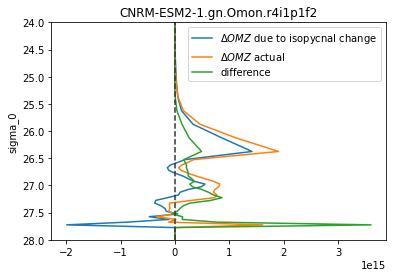

In [59]:
domz_simulated = plot_prep(ds_test_forced_sigma) - plot_prep(ds_test_hist_sigma)
domz_actual = plot_prep(ds_forced) - plot_prep(ds_hist)

plt.figure()
domz_simulated.plot(
    y="sigma_0", label="$\Delta OMZ$ due to isopycnal change"
)
domz_actual.plot(y="sigma_0", label="$\Delta OMZ$ actual")
(domz_actual - domz_simulated).plot(y="sigma_0", label="difference")

plt.axvline(0, color="0.2", ls='--')
plt.ylim(28, 24)
plt.legend()

plt.title(name)
plt.show()


In [ ]:
ds